<a href="https://colab.research.google.com/github/ArtyomHov/tensorflow-zero-to-mastery/blob/master/08_introduction_to_nlp_in_tensorflow_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to NLP Fundamentals in TensorFlow

NLP has the goal of deriving information out of natural language (could be sequences text or speech)
Another common term for NLP problems is sequence problems (seq2seq)

### Get helper functions

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2025-03-16 16:53:06--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.4’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2025-03-16 16:53:07 (12.5 MB/s) - ‘helper_functions.py.4’ saved [10246/10246]



## Get a text dataset

The dataset we are going to be using is Kaggle's introduction to NLP datset (text samples of Tweets labeled as disaster or not dataset).
See the original source here: https://www.kaggle.com/c/nlp-getting-started

In [2]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# Unzip data
unzip_data("nlp_getting_started.zip")

--2025-03-16 16:53:10--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.17.123, 172.217.17.155, 172.217.20.91, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.17.123|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip.4’

nlp_getting_started 100%[===================>] 593.11K  1.68MB/s    in 0.3s    

2025-03-16 16:53:10 (1.68 MB/s) - ‘nlp_getting_started.zip.4’ saved [607343/607343]



## Visualizing a text dataset

## Visualizing a text dataset

To visualize our text samples, we first have to read them in, one way to do so would be to use Python: https://realpython.com/read-write-file-python/
But I prefer to get visual straight away.
So another way to do this is to use pandas...

In [3]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [5]:
# What does the test dataframe look like?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
# How many examples of each class?
train_df.target.value_counts()

,count
target,
0,4342
1,3271


In [7]:
# How many total samples
len(train_df), len(test_df)

(7613, 3263)

In [8]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")


Target: 0 (not real disaster)
Text:
inundated with Westeros Between Storm of Swords as a book on tape &amp; finishing S5 of Game of Thrones I don't know my Starks from my Greyjoys.

---

Target: 0 (not real disaster)
Text:
kenny holland crush da vida

---

Target: 0 (not real disaster)
Text:
Hail Mary Full of Grace The Lord is with thee. Blessed art thou among women and blessed is the fruit of thy... http://t.co/IDQcfJycYM

---

Target: 1 (real disaster)
Text:
The people who tweet and care about #Japan #Fukushima nuclear disaster are not the problem those who ignore are the problem.

---

Target: 0 (not real disaster)
Text:
Timestack' Photos Collapse Entire Sunsets Into Single Mesmerizing Images. http://t.co/Cas8xC2DFE

---



### Split data into training and validation sets

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # Use 10% of training data for validation split
                                                                            random_state=42) # Random state for reproducibility

In [11]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [12]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Converting text into numbers

When dealing with a test problem, one of the first things you'll have to do before you can build a model is to convert your text to numbers.

There are a few ways to do this, namely:
* Tokenization - direct mapping of token (a token could be a word or a character) to number
* Embedding - create a matrix of feature vector for each tolken (the size of the feature vector can be defined and this embedding can be learned)

### Text vectorization (tokenization)

In [13]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocalubary (automatically add <OOV>)
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None, # create groups of n-words
                                    output_mode='int', #how to map tokens to numbers
                                    output_sequence_length=None, # how long should the output sequence of tokens be?
                                    pad_to_max_tokens=False)

In [15]:
train_sentences[0].split()

['@mogacola', '@zamtriossu', 'i', 'screamed', 'after', 'hitting', 'tweet']

In [16]:
# Find the average number of tokens (words) in the training tweets.
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [17]:
# Setup text vectorization variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [18]:
# Fit the text vectorizer to the training data
text_vectorizer.adapt(train_sentences)

In [19]:
train_sentences[:10]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk',
       '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
       'destroy the free fandom honestly',
       'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
       '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
       'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
      dtype=object)

In [20]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [21]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
Stretcher-bearers were soldiers whose job was to follow behind the advance and bring the wounded back into their... http://t.co/yeRcT4J244      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[8021,   67, 1362, 4249,  704,   23,    5, 1023, 1039,    2, 2571,
           7,  962,    2,  269]])>

In [22]:
# Get the unique words in the vocamulary
words_in_vocab = text_vectorizer.get_vocabulary() # get all of the unique words in the vocabulary
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown")
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using an Embedding Layer

To make embedding, we're going to use Tensorflow's embedding layer: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

The parameters we care most about for our embedding layer:
* `input_dim` = the size of our vocabulary
* `output_dim` = the size of the output embedding vector, for example, a value of 100 would mean each token gets represented by a vector 100 long
* `input_length` = length of the sequences being passed to the embedding layer

In [23]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128) #output shape
embedding

<Embedding name=embedding, built=False>

In [24]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
I have my final tomorrow ?????? . Ish is stressful  but I'll survive      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.04568465,  0.00871814, -0.0139073 , ...,  0.04110617,
          0.01136393, -0.04461458],
        [ 0.02853615, -0.02837683,  0.02541014, ...,  0.03205599,
          0.01059876, -0.01845797],
        [ 0.03066279, -0.0353932 ,  0.01872093, ..., -0.0426128 ,
         -0.03760691, -0.00124186],
        ...,
        [ 0.03416684,  0.02454222, -0.00730097, ...,  0.02970693,
          0.03144893,  0.0435865 ],
        [ 0.03416684,  0.02454222, -0.00730097, ...,  0.02970693,
          0.03144893,  0.0435865 ],
        [ 0.03416684,  0.02454222, -0.00730097, ...,  0.02970693,
          0.03144893,  0.0435865 ]]], dtype=float32)>

In [25]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-0.04568465,  0.00871814, -0.0139073 , -0.035795  ,  0.02688118,
        -0.00860556,  0.02220279, -0.01565226, -0.01308925, -0.00936677,
         0.02919007,  0.0384027 ,  0.00746883,  0.04149218, -0.04253136,
         0.01077645, -0.00734865,  0.041796  ,  0.02320078, -0.01488072,
        -0.01132722,  0.02988598,  0.00411366,  0.0257545 , -0.02432188,
        -0.02460665,  0.01377398,  0.03825647,  0.04529356, -0.03593125,
         0.01279277, -0.00589854,  0.04474814,  0.00059109, -0.00582025,
         0.04953858,  0.04180206, -0.00660161, -0.00882677, -0.01399635,
         0.02532151,  0.01413691, -0.03300269, -0.04807809,  0.01971098,
         0.00242785, -0.03879032, -0.00461249, -0.00317435,  0.01809807,
         0.00277994, -0.04483587, -0.01569691, -0.0183786 , -0.01188987,
        -0.00886267, -0.03526801, -0.03214021, -0.04593469,  0.01286692,
         0.012566  , -0.00541671,  0.00395149, -0.04148389, -0.01184564,
  

## Modeling a text dataset (running a series of experiments)

Now we've got a way to turn our text sequences into numbers, it's time to start building a series of modelling experiments.

We'll start with a baseline and move on from there.

* Model 0: Naive Bayes (baseline)
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidirectional-LSTM model (RNN)
* Model 5: ID Convolutional Neural Network (CNN)
* Model 6: Tensorflow Hub Pretrained Feature Extractor (using transfer learning for NLP)
* Model 7: Same as model 6 with 10% of training data

How are we going to approach these?

Use the standard steps in modelling with tensorflow:

* Create a model
* Build a model
* Fit a model
* Evaluate our model

### Model 0: Getting a baseline

As with all machine learning modelling experiments, it's important to create a baseline model so you've got a benchmark for future experiments to build upon.FutureWarning

To create our baseline, we'll use Sklearn's Multinomial Naive Bayes using the TF-IDF formula to convert our words to numbers.

**Note:** It's common practice to use non-DL algorithms as a baseline because of their speed and then later using DL to see if you can improve upon them.

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [27]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [28]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating an evaluation function for our model experiments

We could evaluate all of our model's predictions with different metrics every time, however, this will be cumbersome and could easily be fixed with a function

Let's create one to compare our model's predictions with the truth labels using the following make_strictly_feasible
* Accuracy
* Precision
* Recall
* F1-Score

For a deep overview of many different evaluation methods, see the Sklearn documentation: https://scikit-learn.org/stable/modules/model-evaluation.html

In [29]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [30]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 1: A simple dense model

In [31]:
# Create a tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create a directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [32]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string) # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numberized inputs
x = layers.GlobalAveragePooling1D(name="global_avg_pool_layer")(x) # condense the feature vector for each token to one vector
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

In [33]:
model_1.summary()

Model: "model_1_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_avg_pool_layer                │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,280,129 (4.88 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [35]:
# Fit the model
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20250316-165311
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6380 - loss: 0.6506 - val_accuracy: 0.7703 - val_loss: 0.5331
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8162 - loss: 0.4620 - val_accuracy: 0.7835 - val_loss: 0.4717
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8616 - loss: 0.3523 - val_accuracy: 0.7887 - val_loss: 0.4596
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8904 - loss: 0.2921 - val_accuracy: 0.7874 - val_loss: 0.4665
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9155 - loss: 0.2353 - val_accuracy: 0.7795 - val_loss: 0.4813


In [36]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - accuracy: 0.7696 - loss: 0.5105


[0.4812673032283783, 0.7795275449752808]

In [37]:
# Make some predictions and evaluate those
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape
# model_1_preds = tf.squeeze(tf.round(model_1_pred_probs)) # round out predictions to the nearest integer

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


(762, 1)

In [38]:
# Convert model prediction probabilites to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [39]:
# calculate our model_1 results
model_1_results = calculate_results(y_true=val_labels,
                                  y_pred=model_1_preds)
model_1_results

{'accuracy': 77.95275590551181,
 'precision': 0.7802422774076316,
 'recall': 0.7795275590551181,
 'f1': 0.7781078501550943}

In [40]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [41]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

## Visualizing learned embeddings

In [42]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [43]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_avg_pool_layer                │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,840,389 (14.65 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,560,260 (9.77 MB)

Now we've got the embedding matrix our model has learned to represent our token, let's see how we can visualize it.

To do so, Tensorflow has a handy tool called projector: http://projector.tensorflow.org/

And Tnsorflow also has an incredible guide on word embeddings themselves.

In [44]:
# Get the weight matrix of embedding layer
# (these are the numerical representations of each token in our training data, which have been learned for 5 epochs)
embed_weights = model_1.get_layer("embedding").get_weights()
embed_weights[0].shape # same size as vocab size and embedding_dim (output_dim of our embedding layer)

(10000, 128)

In [45]:
# Create embedding files (we got this from TensorFlow's word embeddings documentation)
import io
out_v = io.open("vectors.tsv", "w", encoding="utf-8")
out_m = io.open("metadata.tsv", "w", encoding="utf-8")

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue # skip 0, it's padding
  vec = embed_weights[0][index]
  out_v.write("\t".join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [46]:
# Download files from Colab to upload to projector
try:
  from google.colab import files
  files.download("vectors.tsv")
  files.download("metadata.tsv")
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Recurrent Neural Networks (RNN's)

RNN's are useful for sequence data.

The premise of a recurrent neural network is to use the representation of a previous input to aid the representation of a layer input.

Internals of a recurrent neural network:
- MIT sequence modelling lecture https://youtu.be/qjrad0V0uJE
- Chris Olah's intros to LSTMs: https://colah.github.io/posts/2015-08-Understanding-LSTMs/
- Andrej Karpathy's the unreasonable effectiveness of RNNs https://karpathy.github.io/2015/05/21/rnn-effectiveness/

### Model 2: LSTM

LSTM = long short term memory (one of the most popular LSTM cells)

Our structure of an RNN typically looks lie this:

```
Input (text) -> Tokenize -> Embedding -> Layers (RNNs/dense) -> Output (label probability)
```

In [47]:
# Create an LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
# print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True
# print(x.shape)
x = layers.LSTM(64)(x)
# print(x.shape)
# x = layers.Dense(64, activation="relu")(x)
# print(x.shape)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

In [48]:
# Get a summary
model_2.summary()

Model: "model_2_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,329,473 (5.07 MB)

 Trainable params: 1,329,473 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
# Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [50]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                             train_labels,
                             epochs=5,
                             validation_data=(val_sentences, val_labels),
                             callbacks=[create_tensorboard_callback(SAVE_DIR, "model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20250316-165319
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9049 - loss: 0.3018 - val_accuracy: 0.7835 - val_loss: 0.5792
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9428 - loss: 0.1559 - val_accuracy: 0.7835 - val_loss: 0.6066
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9501 - loss: 0.1304 - val_accuracy: 0.7756 - val_loss: 0.7112
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9628 - loss: 0.1019 - val_accuracy: 0.7769 - val_loss: 0.8327
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9683 - loss: 0.0825 - val_accuracy: 0.7808 - val_loss: 0.8876


In [51]:
# Make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


array([[8.3673745e-02],
       [9.2737234e-01],
       [9.9965912e-01],
       [8.2882226e-02],
       [9.0127671e-04],
       [9.9848312e-01],
       [8.3399022e-01],
       [9.9975544e-01],
       [9.9963260e-01],
       [2.8857121e-01]], dtype=float32)

In [52]:
# Convert model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [53]:
# Calculate model 2 results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 78.08398950131233,
 'precision': 0.781027063798433,
 'recall': 0.7808398950131233,
 'f1': 0.7797836213601502}

In [54]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 3: GRU

Another popular and effective RNN componen is the GRU or gated recurrent unit.

The GRU cell has similar features to an LSTM cell but has less parameters.

In [55]:
# Build an RNN using the GRU cell
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x) # if you want to stack recurrent layers on top of each other, you need return sequnces = True
# x = layers.LSTM(64, return_sequences=True)(x)
# x = layers.GRU(64)(x)
# x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [56]:
model_3.summary()

Model: "model_3_GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 64)                  │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,317,313 (5.03 MB)

 Trainable params: 1,317,313 (5.03 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
# Compile the model
model_3.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [58]:
# Fit the model
model_3_hitory = model_3.fit(train_sentences,
                          train_labels,
                          epochs=5,
                          validation_data=(val_sentences, val_labels),
                          callbacks=[create_tensorboard_callback(SAVE_DIR, "model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20250316-165330
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8728 - loss: 0.2798 - val_accuracy: 0.7717 - val_loss: 0.8361
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9699 - loss: 0.0848 - val_accuracy: 0.7769 - val_loss: 0.7790
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9735 - loss: 0.0686 - val_accuracy: 0.7690 - val_loss: 0.8443
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9784 - loss: 0.0558 - val_accuracy: 0.7664 - val_loss: 0.9871
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9780 - loss: 0.0536 - val_accuracy: 0.7730 - val_loss: 1.1480


In [59]:
# Make some predictions with our GRU model
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


array([[9.0529603e-01],
       [8.5594374e-01],
       [9.9956357e-01],
       [1.4174736e-01],
       [6.2201267e-05],
       [9.9916649e-01],
       [9.3492025e-01],
       [9.9987382e-01],
       [9.9979162e-01],
       [6.1052406e-01]], dtype=float32)

In [60]:
# Convert model 3 pred probs to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [61]:
# Calculate model 3 results
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 77.29658792650919,
 'precision': 0.7726091269398356,
 'recall': 0.7729658792650919,
 'f1': 0.772485380005067}

### Model 4: Bidirectional RNN

Normal RNN's go from left to right (just like you'd read an English sentence), however, a bidirectional RNN goes from right to left as well as left to right.

In [62]:
# Build a bidirectional RNN in TensorFlow.
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.GRU(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidirectional")

In [63]:
# Get a summary
model_4.summary()

Model: "model_4_bidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 15, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,453,441 (5.54 MB)

 Trainable params: 1,453,441 (5.54 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
# Compile model
model_4.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [65]:
# Fit the model
model_4_history = model_4.fit(train_sentences,
                            train_labels,
                            epochs=5,
                            validation_data=(val_sentences, val_labels),
                            callbacks=[create_tensorboard_callback(SAVE_DIR, "model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20250316-165341
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.9534 - loss: 0.1725 - val_accuracy: 0.7743 - val_loss: 0.9719
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9761 - loss: 0.0556 - val_accuracy: 0.7743 - val_loss: 1.0055
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9811 - loss: 0.0474 - val_accuracy: 0.7690 - val_loss: 1.3474
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9813 - loss: 0.0453 - val_accuracy: 0.7730 - val_loss: 1.2555
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9807 - loss: 0.0397 - val_accuracy: 0.7638 - val_loss: 1.5237


In [66]:
# Make predictions with our bidirectional model
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


array([[2.3078204e-03],
       [7.6369649e-01],
       [9.9998337e-01],
       [8.4137201e-02],
       [2.3257062e-05],
       [9.9954700e-01],
       [7.6580912e-01],
       [9.9999350e-01],
       [9.9998552e-01],
       [9.8667109e-01]], dtype=float32)

In [67]:
# Convert pred probs to pred labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [68]:
# Calculate the results of our bidirectional model
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 76.37795275590551,
 'precision': 0.7642156268927923,
 'recall': 0.7637795275590551,
 'f1': 0.7622584108804582}

In [69]:
model_3_results

{'accuracy': 77.29658792650919,
 'precision': 0.7726091269398356,
 'recall': 0.7729658792650919,
 'f1': 0.772485380005067}

## Convolutional Neural Networks for text (and other types of sequences)

We've used CNNs for images but images are typically 2D (height x width)... however, our text is 1D

Previously we've Conv2D for our image data but now we're going to use Conv1D.

The typical structure a Conv1D model model for sequences in our case text, looks like this:

```
Inputs (text) -> Tokenization = Embedding -> Layer(s)
(typically Conv1D + pooling) -> Outputs (class probabilites)
```

### Model 5: Conv1D

For different explanations of parameters see:
* https://poloclub.github.io/cnn-explainer/ (this is fot 2D but can realte to 1D data)
* Difference between "same" and "valid" padding: https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t

In [70]:
# Test out our embedding layer, Conv1D layer and max pooling
from tensorflow.keras import layers
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sequence into embedding
conv_1d = layers.Conv1D(filters=32,
                        kernel_size=5, # this is also referred to as an ngram of 5 (meaning it looks at 5 words at a time)
                        activation="relu",
                        padding="same") # default = "valid", the output is smaller than the input shape, "same" means output is the same shape as input
conv_1d_output = conv_1d(embedding_test) # pass test embedding through conv1d layer
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # equivalent to "get the most important feature" or "get the feature with the highest value"
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 15, 32]), TensorShape([1, 32]))

In [71]:
embedding_test

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.04504641,  0.04657238,  0.06973285, ...,  0.10241682,
          0.003752  ,  0.0236115 ],
        [-0.00888264, -0.00137019,  0.02200795, ..., -0.04010928,
         -0.03156785, -0.02950532],
        [ 0.02161663, -0.00827548, -0.01329467, ...,  0.0216251 ,
         -0.02206269,  0.02066477],
        ...,
        [-0.00106983,  0.03582036,  0.00446003, ..., -0.00244657,
          0.02062197,  0.06761738],
        [-0.00106983,  0.03582036,  0.00446003, ..., -0.00244657,
          0.02062197,  0.06761738],
        [-0.00106983,  0.03582036,  0.00446003, ..., -0.00244657,
          0.02062197,  0.06761738]]], dtype=float32)>

In [72]:
conv_1d_output

<tf.Tensor: shape=(1, 15, 32), dtype=float32, numpy=
array([[[0.        , 0.        , 0.        , 0.01749256, 0.        ,
         0.        , 0.        , 0.        , 0.00069255, 0.        ,
         0.        , 0.        , 0.09582707, 0.04739762, 0.0136687 ,
         0.        , 0.        , 0.        , 0.03664298, 0.00072644,
         0.        , 0.        , 0.00877956, 0.05697142, 0.        ,
         0.        , 0.01102233, 0.03410711, 0.        , 0.11112129,
         0.05092349, 0.        ],
        [0.        , 0.        , 0.        , 0.03547138, 0.00716653,
         0.        , 0.03574982, 0.03342296, 0.00977992, 0.05639684,
         0.        , 0.00608886, 0.        , 0.02098655, 0.05399561,
         0.        , 0.        , 0.        , 0.01754261, 0.05520828,
         0.06490681, 0.        , 0.        , 0.02804499, 0.0209724 ,
         0.        , 0.01387723, 0.        , 0.04319505, 0.03089604,
         0.        , 0.06698995],
        [0.01944183, 0.00168982, 0.        , 0.0625

In [73]:
max_pool_output

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[0.01944183, 0.00168982, 0.00483552, 0.06250007, 0.06005078,
        0.01248596, 0.03574982, 0.05154546, 0.00977992, 0.05639684,
        0.        , 0.10555802, 0.09582707, 0.04739762, 0.07120641,
        0.00543651, 0.02646601, 0.02816984, 0.03664298, 0.05520828,
        0.06490681, 0.10566276, 0.00877956, 0.05697142, 0.06749482,
        0.12569803, 0.04416789, 0.06131583, 0.0726754 , 0.11112129,
        0.05092349, 0.06698995]], dtype=float32)>

In [74]:
# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, strides=1, activation="relu", padding="valid")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile Conc1D
model_5.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Get a summary of our Conv1D model
model_5.summary()

Model: "model_5_Conv1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 11, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,321,089 (5.04 MB)

 Trainable params: 1,321,089 (5.04 MB)

 Non-trainable params: 0 (0.00 B)

In [75]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "conv1D")])

Saving TensorBoard log files to: model_logs/conv1D/20250316-165401
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9557 - loss: 0.1885 - val_accuracy: 0.7625 - val_loss: 0.9290
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9748 - loss: 0.0742 - val_accuracy: 0.7664 - val_loss: 1.0381
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9765 - loss: 0.0566 - val_accuracy: 0.7493 - val_loss: 1.1528
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9782 - loss: 0.0516 - val_accuracy: 0.7585 - val_loss: 1.1567
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9750 - loss: 0.0506 - val_accuracy: 0.7493 - val_loss: 1.2433


In [76]:
# Make some predictions with our Conv1D model
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


array([[1.15643635e-01],
       [7.35529423e-01],
       [9.99912500e-01],
       [6.54128492e-02],
       [2.58960089e-08],
       [9.83811259e-01],
       [9.95420456e-01],
       [9.99968052e-01],
       [9.99998391e-01],
       [6.97278619e-01]], dtype=float32)

In [77]:
# Convert model 4 pred probs to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [78]:
# Evaluate model 5 predictions
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 74.93438320209974,
 'precision': 0.7512456879811593,
 'recall': 0.7493438320209974,
 'f1': 0.7465531243537884}

In [79]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

## Model 6: Tensorflow hub pretrained sentence encoder

Now we've built a few of our own models, let's try and use transfer learning for NLP, specifically using TensorFlow Hub's Universal Sentence Encoder: https://tfhub.dev/google/universal-sentence-encoder/4

See how the USE as created here: https://arxiv.org/abs/1803.11175

In [80]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence,
                       'When you call the universal sentence encoder on a sentence, it turns it into numbers.'])
print(embed_samples[0][:50])

tf.Tensor(
[-0.01157025  0.02485911  0.02878051 -0.012715    0.03971541  0.08827761
  0.02680988  0.05589838 -0.01068731 -0.00597293  0.00639321 -0.01819516
  0.00030816  0.09105889  0.05874645 -0.03180629  0.01512474 -0.05162925
  0.00991366 -0.06865345 -0.04209306  0.0267898   0.03011009  0.00321065
 -0.00337968 -0.04787356  0.0226672  -0.00985927 -0.04063615 -0.01292093
 -0.04666382  0.05630299 -0.03949255  0.00517682  0.02495827 -0.07014439
  0.0287151   0.0494768  -0.00633978 -0.08960193  0.02807119 -0.00808364
 -0.01360601  0.05998649 -0.10361788 -0.05195372  0.00232958 -0.02332531
 -0.03758106  0.03327729], shape=(50,), dtype=float32)


In [81]:
embed_samples[0].shape

TensorShape([512])

In [82]:
# Create a Keras layer using the USE pretrained layer from tensorflow hub
import tensorflow as tf
import tensorflow_hub as hub
# from tensorflow.keras import layers

sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],  # Shape of the input text
                                        dtype=tf.string,  # Data type of the input
                                        trainable=False,
                                        name="USE")  # Set to True if you want to fine-tune

In [83]:
# Create a model using Sequential API
import tf_keras
from tf_keras import layers, models
input_text = layers.Input(shape=[], dtype=tf.string)
x = sentence_encoder_layer(input_text)
x = layers.Dense(64, activation="relu")(x)
output = layers.Dense(1, activation='sigmoid')(x)

model_6 = models.Model(inputs=input_text, outputs=output, name="model_6_USE")

# Compile
model_6.compile(loss="binary_crossentropy",
                optimizer=tf_keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [84]:
# train a cllassifier on top of USE pretrained embeddings
model_6_hitory = model_6.fit(train_sentences,
                            train_labels,
                            epochs=5,
                            validation_data=(val_sentences, val_labels),
                            callbacks=[])

Epoch 1/5
215/215 [==============================] - 3s 7ms/step - loss: 0.5050 - accuracy: 0.7854 - val_loss: 0.4512 - val_accuracy: 0.7927
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.4149 - accuracy: 0.8154 - val_loss: 0.4387 - val_accuracy: 0.8058
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.4007 - accuracy: 0.8228 - val_loss: 0.4395 - val_accuracy: 0.8110
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.3932 - accuracy: 0.8256 - val_loss: 0.4382 - val_accuracy: 0.8097
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.3867 - accuracy: 0.8298 - val_loss: 0.4256 - val_accuracy: 0.8202


In [85]:
# Make predictions with USE TF Hub Model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 0s 4ms/step


array([[0.20526987],
       [0.8460761 ],
       [0.99150366],
       [0.21378917],
       [0.8001828 ],
       [0.7260828 ],
       [0.98572934],
       [0.978598  ],
       [0.95437235],
       [0.10931573]], dtype=float32)

In [86]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [87]:
# calculate model 6 performance metrics
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 82.02099737532808,
 'precision': 0.8208980546834477,
 'recall': 0.8202099737532809,
 'f1': 0.8193434498583269}

In [88]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}



## Model 7: TF Hub Pretrained USE but with 10% of training data

Transfer learning really helps when you don't have a large dataset.

To see how our model performs on a smaller dataset, let's replicate model_6 except we'll train it on 10% of the data.

In [89]:
## Note: making data splits like below leads to data leakage (model_7 trained on 10% of data, outperforms model_6 trained on 100% of data)
## DO NOT MAKE DATA SPLITS WHICH LEAK DATA FROM VALIDATION/TEST SETS INTO TRAINING SET

# Create subsets of 10% of the training data
# train_10_percent = train_df_shuffled[['text', 'target']].sample(frac=0.1, random_state=42)
# train_sentences_10_percent = train_10_percent["text"].to_list()
# train_labels_10_percent = train_10_percent["target"].to_list()
# len(train_sentences_10_percent), len(train_labels_10_percent)

In [90]:
# Making a better dataset split (no data leakage)
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [91]:
# Check the number of each label in the updated training data subset
pd.Series(train_labels_10_percent).value_counts()

,count
0,406
1,279


In [92]:
# Check the number of targets in our subset of data
train_df_shuffled["target"].value_counts()
#

,count
target,
0,4342
1,3271


To recreate a model the same as a previous model you've created you can use the `tf.keras.models.clone_model()` method, see more here: https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model

In [93]:
# Let's build a model the same as model_6
model_7 = tf_keras.models.clone_model(model_6)

# Compile model
model_7.compile(loss='binary_crossentropy',
                optimizer=tf_keras.optimizers.Adam(),
                metrics=['accuracy'])
# Get a summary (will be same as model_6)
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [94]:
# Fit the model
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[])

Epoch 1/5
22/22 [==============================] - 2s 22ms/step - loss: 0.6737 - accuracy: 0.6496 - val_loss: 0.6517 - val_accuracy: 0.7270
Epoch 2/5
22/22 [==============================] - 0s 10ms/step - loss: 0.6047 - accuracy: 0.8044 - val_loss: 0.5940 - val_accuracy: 0.7546
Epoch 3/5
22/22 [==============================] - 0s 9ms/step - loss: 0.5272 - accuracy: 0.8131 - val_loss: 0.5383 - val_accuracy: 0.7651
Epoch 4/5
22/22 [==============================] - 0s 10ms/step - loss: 0.4634 - accuracy: 0.8234 - val_loss: 0.5008 - val_accuracy: 0.7743
Epoch 5/5
22/22 [==============================] - 0s 10ms/step - loss: 0.4210 - accuracy: 0.8263 - val_loss: 0.4886 - val_accuracy: 0.7782


In [95]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 0s 4ms/step


array([[0.19142962],
       [0.5543507 ],
       [0.9201564 ],
       [0.36795285],
       [0.5424907 ],
       [0.6598592 ],
       [0.9005032 ],
       [0.8100472 ],
       [0.87080026],
       [0.16193856]], dtype=float32)

In [96]:
# Turn pred probs into labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [97]:
# Evaluate model_7 predictions
model_7_results = calculate_results(y_true=val_labels,
                                    y_pred=model_7_preds)
model_7_results

{'accuracy': 77.82152230971128,
 'precision': 0.7801652612118941,
 'recall': 0.7782152230971129,
 'f1': 0.7761410008648765}

In [98]:
model_6_results

{'accuracy': 82.02099737532808,
 'precision': 0.8208980546834477,
 'recall': 0.8202099737532809,
 'f1': 0.8193434498583269}

## Comparing the performance of each of our models

In [99]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({'0_baseline': baseline_results,
                                  '1_simple_dense': model_1_results,
                                  '2_lstm': model_2_results,
                                  '3_gru': model_3_results,
                                  '4_bidirectional': model_4_results,
                                  '5_conv1d': model_5_results,
                                  '6_tf_hub_use_encoder': model_6_results,
                                  '7_tf_hub_use_encoder_10_percent': model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
0_baseline,79.265092,0.811139,0.792651,0.786219
1_simple_dense,77.952756,0.780242,0.779528,0.778108
2_lstm,78.083990,0.781027,0.780840,0.779784
3_gru,77.296588,0.772609,0.772966,0.772485
4_bidirectional,76.377953,0.764216,0.763780,0.762258
5_conv1d,74.934383,0.751246,0.749344,0.746553
6_tf_hub_use_encoder,82.020997,0.820898,0.820210,0.819343
7_tf_hub_use_encoder_10_percent,77.821522,0.780165,0.778215,0.776141


In [100]:
# Reduce the accuracy to the same scale as other metrics
all_model_results['accuracy'] = all_model_results['accuracy']/100
all_model_results

,accuracy,precision,recall,f1
0_baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.779528,0.780242,0.779528,0.778108
2_lstm,0.780840,0.781027,0.780840,0.779784
3_gru,0.772966,0.772609,0.772966,0.772485
4_bidirectional,0.763780,0.764216,0.763780,0.762258
5_conv1d,0.749344,0.751246,0.749344,0.746553
6_tf_hub_use_encoder,0.820210,0.820898,0.820210,0.819343
7_tf_hub_use_encoder_10_percent,0.778215,0.780165,0.778215,0.776141


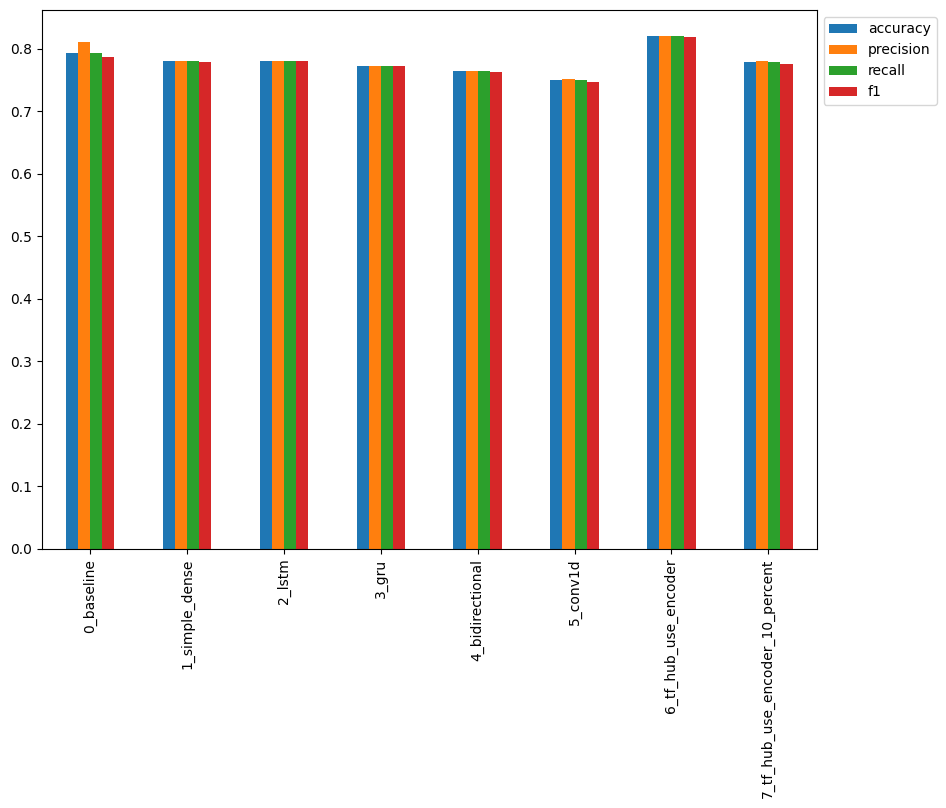

In [101]:
# Plot and compare all of the model results
all_model_results.plot(kind='bar', figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

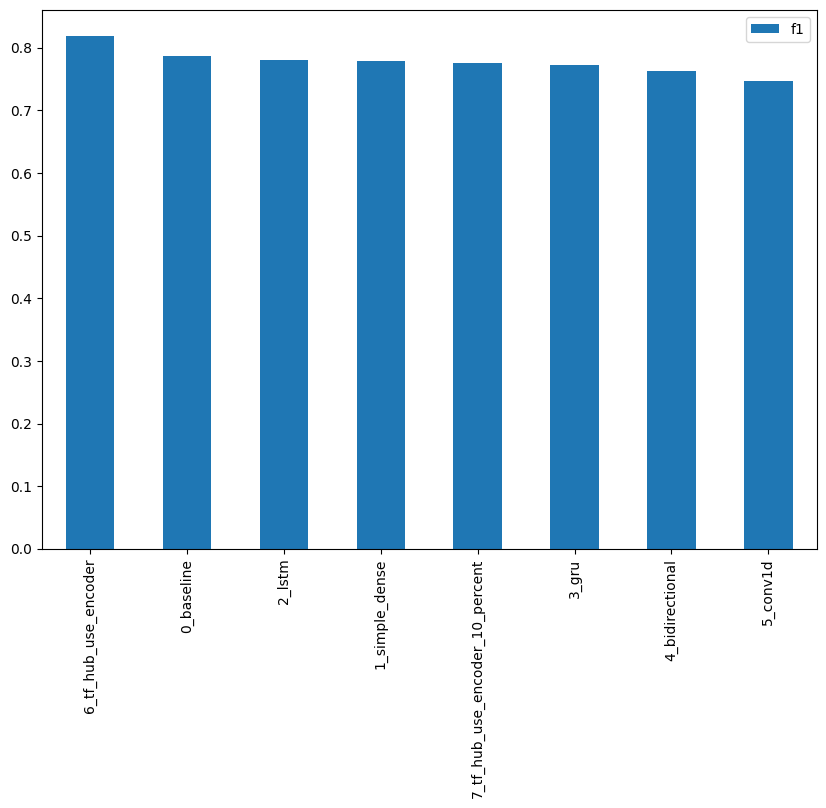

In [102]:
# Sort model results by F1-score
all_model_results.sort_values('f1', ascending=False)['f1'].plot(kind='bar', figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

## Saving and loading a trained model

There are two main formats to save a model in TensorFlow:
1. The HDF5 format
2. The `SavedModel` format (this is the default when using TensorFlow)

In [103]:
# Save TF Hub Sentence Encodel model to HDF5 format
model_6.save("model_6.h5")

/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [104]:
# Load model with custom Hub Layer (required HDF5 format)
loaded_model_6 = tf_keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [106]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 4ms/step - loss: 0.4256 - accuracy: 0.8202


[0.4256417453289032, 0.8202099800109863]

Now let's save to the `SavedModel` format (default)

In [107]:
# Save TF Hub Sentence Encoder model to SavedModel format (default)
model_6.save("model_6_saved_model")

In [108]:
# Load in a model from SavedModel format
loaded_model_6_saved = tf_keras.models.load_model("model_6_saved_model")

In [109]:
# Evaluate model in SavedModel format
loaded_model_6_saved.evaluate(val_sentences, val_labels)


24/24 [==============================] - 0s 4ms/step - loss: 0.4256 - accuracy: 0.8202


[0.4256417453289032, 0.8202099800109863]

## Finding the most wrong examples

* If our best model still isn't perfect, what examples is it getting wrong?
* And of these wrong examples which ones is it getting *most* wrong (those will have prediction probabilities closest tot he opposite class)

For example if a sample should have a label of 0 but our model predicts a prediction probability of 0.999 (really close to 1) and vice versa.

In [112]:
# Download a pretrained model from Google Storage
!wget "https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip"
!unzip 08_model_6_USE_feature_extractor.zip

--2025-03-16 17:07:56--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.214.155, 142.250.184.155, 142.250.187.123, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.214.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M  33.9MB/s    in 35s     

2025-03-16 17:08:32 (26.1 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variables

In [113]:
# Import previously trained model from Google Storage
model_6_pretrained = tf_keras.models.load_model("08_model_6_USE_feature_extractor")
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 4ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723119258880615, 0.8162729740142822]

In [114]:
# Make predictions with the loaded model from GS
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds[:10] # these should be in label format

24/24 [==============================] - 0s 4ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [117]:
# Create DataFrame with validation sentences, validation labels and best performing model prediction labels + probabilities
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_pretrained_preds,
                       "pred_prob": tf.squeeze(model_6_pretrained_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [118]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong.head(10) # these are false positives

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.814816
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.810840
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.803122
119,@freefromwolves GodsLove &amp; #thankU brother...,0,1.0,0.766901
344,Air Group is here to the rescue! We have 24/7 ...,0,1.0,0.766625


Let's remind ourselves of the target labels...
* 0 = not disaster
* 1 = disaster

In [119]:
most_wrong.tail() # these are false negatives

,text,target,pred,pred_prob
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043918
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186


In [121]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples():
  _, text, target, pred, pred_probs = row
  print(f"Target: {target}, Pred: {int(pred)}, Pred Prob: {pred_probs}")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 0, Pred: 1, Pred Prob: 0.9101956486701965
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

---

Target: 0, Pred: 1, Pred Prob: 0.8769821524620056
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

---

Target: 0, Pred: 1, Pred Prob: 0.8523001074790955
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

---

Target: 0, Pred: 1, Pred Prob: 0.8354543447494507
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

---

Target: 0, Pred: 1, Pred Prob: 0.8272131681442261
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

---

Target: 0, Pred: 1, Pred Prob: 0.8148159384727478
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around t

In [123]:
# Check the false negatives (model predicted 1 when should've been 0)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, pred_probs = row
  print(f"Target: {target}, Pred: {int(pred)}, Pred Prob: {pred_probs}")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 1, Pred: 0, Pred Prob: 0.06730349361896515
Text:
@DavidVonderhaar At least you were sincere ??

---

Target: 1, Pred: 0, Pred Prob: 0.055075839161872864
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

---

Target: 1, Pred: 0, Pred Prob: 0.05460338294506073
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

---

Target: 1, Pred: 0, Pred Prob: 0.054596997797489166
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

---

Target: 1, Pred: 0, Pred Prob: 0.04963726922869682
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

---

Target: 1, Pred: 0, Pred Prob: 0.043918464332818985
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

---

Target: 1, Pred: 

## Making predictions on the test dataset

In [127]:
# Making predictions on the test dataset and visualizing
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample])) # our model expexts list as input
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("----\n")

1/1 [==============================] - 0s 29ms/step
Pred: 1, Prob: 0.9674437642097473
Text:
a very scary thought is if 9/11 had happened today their would be teenagers taking selfies in front of the burning buildings

----

1/1 [==============================] - 0s 21ms/step
Pred: 1, Prob: 0.9193528890609741
Text:
#TheSun Flood: Two people dead 60 houses destroyed in Kaduna: Two people have been reportedly killed and 60 h...  http://t.co/Aawmx5w9sh

----

1/1 [==============================] - 0s 23ms/step
Pred: 0, Prob: 0.11462702602148056
Text:
When you get a call back from the interview you thought you bombed &gt;&gt;&gt;

----

1/1 [==============================] - 0s 22ms/step
Pred: 0, Prob: 0.2368115484714508
Text:
I added a video to a @YouTube playlist http://t.co/Ei5Z52tohR Natural Disaster Survival ep.7 '2079 Bacon Hair...'

----

1/1 [==============================] - 0s 22ms/step
Pred: 1, Prob: 0.7488404512405396
Text:
RT MMDA: ADVISORY: Stalled Bus at EDSA Service Road Cub

## The speed/score tradeoff

In [133]:
# Let's make a function to measure the time of prediction
import time
def pred_timer(model, text):
  """
  Times how long it takes the model to make predictions on samples.
  """
  start_time = time.perf_counter() # get start time
  model.predict(text) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time - start_time # calculate how long predictions took to make
  time_per_pred = total_time / len(text) # calculate time per prediction
  return total_time, time_per_pred

In [136]:
# Calculate TF Hub Sentence Encoder time per pred
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model=model_6_pretrained,
                                                            text=val_sentences)
print(f"Total time: {model_6_total_pred_time}, Time per pred: {model_6_time_per_pred}")

24/24 [==============================] - 0s 4ms/step
Total time: 0.15751625085249543, Time per pred: 0.00020671423996390477


In [140]:
# Calculate our baseline model times per pred
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model=model_0,
                                                              text=val_sentences)
print(f"Total time: {baseline_total_pred_time}, Time per pred: {baseline_time_per_pred}")

Total time: 0.01286955876275897, Time per pred: 1.6889184728030145e-05


In [141]:
# Get results for pretrained GS model
model_6_pretrained_results = calculate_results(y_true=val_labels,
                                              y_pred=model_6_pretrained_preds)
model_6_pretrained_results

{'accuracy': 81.62729658792651,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651,
 'f1': 0.8148082644367335}

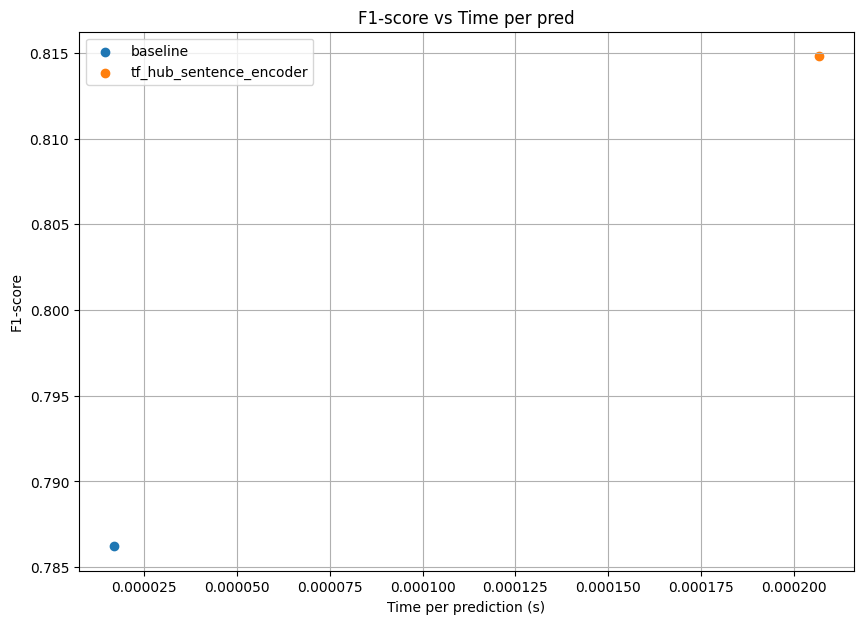

In [142]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_pretrained_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score vs Time per pred")
plt.xlabel("Time per prediction (s)")
plt.ylabel("F1-score")
plt.grid()
